<a href="https://colab.research.google.com/github/klimanyusuf/AI-Capstone-Project-on-E-Commerce-Amazon-Domain-/blob/master/Khalid_Yusuf_Liman_AI_Capstone_Project_E_Commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Task: Week 1

Class Imbalance Problem:

1. Perform an EDA on the dataset.

       a)  See what a positive, negative, and neutral review looks like

       b)  Check the class count for each class. It’s a class imbalance problem.

2. Convert the reviews in Tf-Idf score.

3. Run multinomial Naive Bayes classifier. Everything will be classified as positive because of the class imbalance.

Project Task: Week 2

Tackling Class Imbalance Problem:

    Oversampling or undersampling can be used to tackle the class imbalance problem. 
    In case of class imbalance criteria, use the following metrices for evaluating model performance: precision, recall, F1-score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this      project.
    Use Tree-based classifiers like Random Forest and XGBoost.

       Note: Tree-based classifiers work on two ideologies namely, Bagging or Boosting and have fine-tuning parameter which takes care of the imbalanced class.

Project Task: Week 3

Model Selection:

    Apply multi-class SVM’s and neural nets.
    Use possible ensemble techniques like: XGboost + oversampled_multinomial_NB.
    Assign a score to the sentence sentiment (engineer a feature called sentiment score). Use this engineered feature in the model and check for improvements. Draw insights on the same.

Project Task: Week 4

Applying LSTM:

    Use LSTM for the previous problem (use parameters of LSTM like top-word, embedding-length, Dropout, epochs, number of layers, etc.)

       Hint: Another variation of LSTM, GRU (Gated Recurrent Units) can be tried as well.

      2. Compare the accuracy of neural nets with traditional ML based algorithms.

      3. Find the best setting of LSTM (Neural Net) and GRU that can best classify the reviews as positive, negative, and neutral. 

       Hint: Use techniques like Grid Search, Cross-Validation and Random Search

Optional Tasks: Week 4

Topic Modeling:

   1. Cluster similar reviews.
       Note: Some reviews may talk about the device as a gift-option. Other reviews may be about product looks and some may
          highlight about its battery and performance. Try naming the clusters.
   2. Perform Topic Modeling
       Hint: Use scikit-learn provided Latent Dirchlette Allocation (LDA) and Non-Negative Matrix Factorization (NMF).


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

print("Setup Complete")

Setup Complete


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

print("Setup Complete")

Setup Complete


Using TensorFlow backend.


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test_data.csv to test_data.csv
Saving test_data_hidden.csv to test_data_hidden.csv
Saving train_data.csv to train_data.csv
User uploaded file "test_data.csv" with length 519747 bytes
User uploaded file "test_data_hidden.csv" with length 528718 bytes
User uploaded file "train_data.csv" with length 2074490 bytes


In [ ]:
# Load the data
import pandas as pd
data = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
test_prediction = pd.read_csv('test_data_hidden.csv')

In [ ]:
data.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [ ]:
Positive = data[data['sentiment']== "Positive"].iloc[:,[5,6,7]]
Neutral = data[data['sentiment']== "Neutral"].iloc[:,[5,6,7]]
Negative = data[data['sentiment']== "Negative"].iloc[:,[5,6,7]]

In [ ]:
Positive['sentiment'].value_counts()

Positive    3749
Name: sentiment, dtype: int64

In [ ]:
Neutral['sentiment'].value_counts()

Neutral    158
Name: sentiment, dtype: int64

In [ ]:
Negative['sentiment'].value_counts()

Negative    93
Name: sentiment, dtype: int64

Converting the Reviews as Tf-Idf Score

In [ ]:
# Keeping only those Features that we need for further exploring.
data1 = data [["sentiment","reviews.text"]]

In [ ]:
data1.head()

,sentiment,reviews.text
0,Positive,Purchased on Black FridayPros - Great Price (e...
1,Positive,I purchased two Amazon in Echo Plus and two do...
2,Neutral,Just an average Alexa option. Does show a few ...
3,Positive,"very good product. Exactly what I wanted, and ..."
4,Positive,This is the 3rd one I've purchased. I've bough...


In [ ]:
# Resetting the Index.
data1.index = pd.Series(list(range(data1.shape[0])))

In [ ]:
print('Shape : ',data1.shape)
data1.head()

Shape :  (4000, 2)


,sentiment,reviews.text
0,Positive,Purchased on Black FridayPros - Great Price (e...
1,Positive,I purchased two Amazon in Echo Plus and two do...
2,Neutral,Just an average Alexa option. Does show a few ...
3,Positive,"very good product. Exactly what I wanted, and ..."
4,Positive,This is the 3rd one I've purchased. I've bough...


# **Now we Create Preprocessing Function & Applying it on the Data**

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#Download Stopwords
nltk.download('stopwords')

wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))

def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)

print("Setup Complete")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Setup Complete


In [ ]:
data1['Processed_Review'] = data1['reviews.text'].apply(preprocess)

data1.head()

,sentiment,reviews.text,Processed_Review
0,Positive,Purchased on Black FridayPros - Great Price (e...,purchase black fridaypros great price even sal...
1,Positive,I purchased two Amazon in Echo Plus and two do...,purchase two amazon echo plus two dot plus fou...
2,Neutral,Just an average Alexa option. Does show a few ...,average alexa option show thing screen still l...
3,Positive,"very good product. Exactly what I wanted, and ...",good product exactly want good price
4,Positive,This is the 3rd one I've purchased. I've bough...,rd one purchase buy one niece case compare one...


In [ ]:
data2 = data1 [["sentiment","Processed_Review"]]
data2.head()

,sentiment,Processed_Review
0,Positive,purchase black fridaypros great price even sal...
1,Positive,purchase two amazon echo plus two dot plus fou...
2,Neutral,average alexa option show thing screen still l...
3,Positive,good product exactly want good price
4,Positive,rd one purchase buy one niece case compare one...


Creating TF-IDF Matrix & Multinomial Naive Bayes Classifier

In [ ]:
def textPreprocessing(data2):
    #Remove Punctuation Logic
    import string
    removePunctuation = [char for char in data2 if char not in string.punctuation]
    #Join Chars to form sentences
    sentenceWithoutPunctuations = ''.join(removePunctuation)
    words = sentenceWithoutPunctuations.split()
    #StopwordRemoval
    from nltk.corpus import stopwords
    removeStopwords = [word for word in words if word.lower() not in stopwords.words('english')]
    
    return removeStopwords

In [ ]:
data2.groupby('sentiment').describe()

Processed_Review  ...     
                     count  ... freq
sentiment                   ...     
Negative                93  ...    3
Neutral                158  ...    2
Positive              3749  ...    4

[3 rows x 4 columns]

In [ ]:
#Text preprocessing
data2['Processed_Review'].head(2).apply(textPreprocessing)

0    [purchase, black, fridaypros, great, price, ev...
1    [purchase, two, amazon, echo, plus, two, dot, ...
Name: Processed_Review, dtype: object

Sklearn Package CountVectorizer (For creating Bag of Words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(analyzer=textPreprocessing).fit(data2['Processed_Review'])

In [ ]:
len(bow.vocabulary_)

3407

In [ ]:
reviews_bow = bow.transform(data2['Processed_Review'])

Tf-Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfData = TfidfTransformer().fit(reviews_bow)
tfidfDataFinal = tfidfData.transform(reviews_bow)

In [ ]:
tfidfDataFinal.shape

(4000, 3407)

Now the data is all set for Model Building!

*   Model Training - NaiveBayes Algorithm
*   String Data Handling - MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(tfidfDataFinal,data2['sentiment'])

In [ ]:
model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
inputData = "very bad dont like it at all it sucks"
l1 = textPreprocessing(inputData)
l2 = bow.transform(l1)
l3 = tfidfData.transform(l2)
prediction = model.predict(l3[0])
prediction

array(['Positive'], dtype='<U8')

***Insight***

After running Multinomial Naive Bayes Classifier Everything is classified as positive because of the class imbalance as seen above.

Tackling Class Imbalance Problem:

In [ ]:
#Creating independent and Dependent Features
columns = data2.columns.tolist()
# Filtering the columns to remove data we do not want 
columns = [c for c in columns if c not in ["sentiment"]]
# Store the variable we are predicting 
target = "sentiment"
# Defining a random state 
state = np.random.RandomState(42)
X = data2[columns]
Y = data2[target]
# Printing the shapes of X & Y
print(X.shape)
print(Y.shape)

(4000, 1)
(4000,)


In [ ]:
print(data2.sentiment.value_counts())

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64


Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Distribution of Reviews Sentiment')

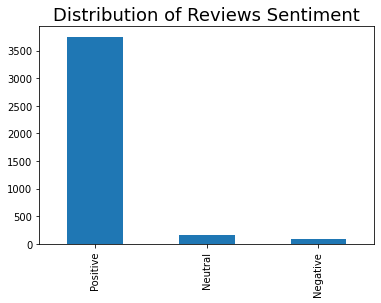

In [ ]:
# Using Matplotlib to show distribution of reviews sentiment in the dataset
print(data1.sentiment.value_counts())
data1['sentiment'].value_counts().plot(kind='bar')
plt.title("Distribution of Reviews Sentiment", size=18)

In [ ]:
print(Positive.shape,Neutral.shape,Negative.shape)

(3749, 3) (158, 3) (93, 3)


Applying Over Sampling

In [ ]:
# RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0) 
X_res,Y_res=ros.fit_sample(X,Y)

In [ ]:
from collections import Counter
print(sorted(Counter(Y_res).items()))

[('Negative', 3749), ('Neutral', 3749), ('Positive', 3749)]


In [ ]:
X_res.shape,Y_res.shape

((11247, 1), (11247,))

In [ ]:
#Checking out both old & new data
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(Y_res)))

Original dataset shape Counter({'Positive': 3749, 'Neutral': 158, 'Negative': 93})
Resampled dataset shape Counter({'Positive': 3749, 'Neutral': 3749, 'Negative': 3749})


In [ ]:
#Creating X output to dataframe
X1=pd.DataFrame(X_res,columns=['Processed_Review'])

In [ ]:
#Creating Y output to dataframe for merging
Y1=pd.DataFrame(Y_res,columns=['sentiment'])

In [ ]:
#Merging the X & Y output to Final data
Final_data=pd.concat([X1,Y1],axis=1)
Final_data.head()

,Processed_Review,sentiment
0,purchase black fridaypros great price even sal...,Positive
1,purchase two amazon echo plus two dot plus fou...,Positive
2,average alexa option show thing screen still l...,Neutral
3,good product exactly want good price,Positive
4,rd one purchase buy one niece case compare one...,Positive


In [ ]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11247 entries, 0 to 11246
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Processed_Review  11247 non-null  object
 1   sentiment         11247 non-null  object
dtypes: object(2)
memory usage: 175.9+ KB


Negative    3749
Neutral     3749
Positive    3749
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Distribution of Reviews Sentiment')

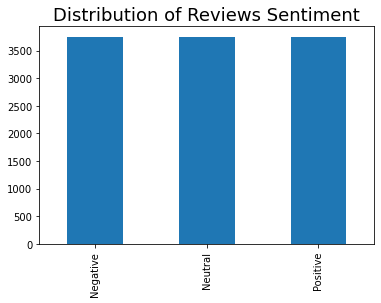

In [ ]:
# Using Matplotlib to plot the final data & show distribution of reviews sentiment in the dataset
print(Final_data.sentiment.value_counts())
Final_data['sentiment'].value_counts().plot(kind='bar')
plt.title("Distribution of Reviews Sentiment", size=18)

In [ ]:
df = Final_data.sample(frac=0.1, random_state=0) 

# Dropping missing values
df.dropna(inplace=True)

df.head()

,Processed_Review,sentiment
8805,buy think would great read book play game howe...,Neutral
9736,good tablet kid lot appts download game,Neutral
125,item work expect great product,Positive
10143,great beginner like child limit use many apps ...,Neutral
10937,buy kindle past time one come defective port b...,Neutral


**Train & Test Split Data**

In [ ]:
# Splitting data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Review'], df['sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 1012 training examples and 113 validation examples. 

Show a review in the training set : 
 daughter love easy navigate hard break


***Bag of Words***

*   The aim of this project is to classify the reviews into positive, neutral and negative sentiment. 

 There are two main steps which are involved:

 1.   We need to find word embedding to convert text into a numerical representation.
 2.   We fit the numerical representations of text to machine learning algorithms or deep learning architectures.


*   One common approach of word embedding is frequency based embedding viz Bag of Words (BoW) model. BoW model learns a vocabulary list from a given corpus and represents each document based on some counting methods of words. Here, we will explore the model performance using BoW with supervised learning algorithms. 

 Here's the workflow of this part.
 1.   Preprocess raw reviews to cleaned reviews.
 2.   Create BoW using CountVectorizer/Tfidfvectorizer in Sklearn.
 3.   Transform review text to numerical representations (feature vectors).
 4.   Fit feature vectors to supervised learning algorithm (Naive Bayes, Logistic regression, etc.).
 5.   Improve the model performance by GridSearch.

***Text Preprocessing***

The following text preprocessing methods are implemented to convert raw reviews to cleaned review making it easier to do feature extraction in the next step.

1.   Remove non-character such as digits and symbols.
2.   Convert to lower case.
3.   Remove stop words such as "the" and "and" if needed.
4.   Convert to root words by stemming if needed.

In [ ]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [ ]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 daughter love easy navigate hard break


In [ ]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 daughter love easy navigate hard break


***CountVectorizer with Multinomial Naive Bayes (Benchmark Model)***

*   Now as we have cleaned all reviews the next step is converting the reviews into numerical representations for a machine learning algorithm.

*   We will use CountVectorizer which implements both tokenization and occurrence counting in a single class provided by the Sklearn library. The output is a sparse matrix representation of the document.


In [ ]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 1511 

Show some feature names : 
 ['ability', 'playtime']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    #print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [ ]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8938

Classification report : 
               precision    recall  f1-score   support

    Negative       0.93      0.95      0.94        39
     Neutral       0.85      0.90      0.88        39
    Positive       0.91      0.83      0.87        35

    accuracy                           0.89       113
   macro avg       0.89      0.89      0.89       113
weighted avg       0.89      0.89      0.89       113


Confusion Matrix : 
 [[37  0  2]
 [ 3 35  1]
 [ 0  6 29]]


***TfidfVectorizer with Logistic Regression***

*   Some words might appear quite frequently but have a very less or negligible meaningful information about the sentiment for a particular review. Instead of using occurance counting we will use tf-idf transform to scale down the impact of frequently appearing words in a given corpus.

*   In sklearn library we will use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [ ]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 691 

Show some feature names : 
 ['able']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Have a look at the top 10 features with the smallest and largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['love' 'easy' 'great' 'play' 'read' 'alexa' 'kid' 'price' 'well' 'enjoy']

Top 10 features with the largest coefficients : 
['return' 'update' 'bad' 'know' 'terrible' 'th' 'poor' 'try' 'minute'
 'youtube']


In [ ]:
# Evaluating on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9292

Classification report : 
               precision    recall  f1-score   support

    Negative       0.93      1.00      0.96        39
     Neutral       0.88      0.92      0.90        39
    Positive       1.00      0.86      0.92        35

    accuracy                           0.93       113
   macro avg       0.94      0.93      0.93       113
weighted avg       0.93      0.93      0.93       113


Confusion Matrix : 
 [[39  0  0]
 [ 3 36  0]
 [ 0  5 30]]


***TfidfVectorizer with Linear SVM by using SGD***

Some words might appear quite frequently but have a very less or negligible meaningful information about the sentiment for a particular review. Instead of using occurance counting we will use tf-idf transform to scale down the impact of frequently appearing words in a given corpus.

In sklearn library we will use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [ ]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# SVM
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train_tfidf, y_train)

Number of features : 691 

Show some feature names : 
 ['able']


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Have a look at the top 10 features with the smallest and largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = clf.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['overall' 'play' 'well' 'sometimes' 'love' 'easy' 'great' 'age'
 'definitely' 'control']

Top 10 features with the largest coefficients : 
['terrible' 'return' 'exchange' 'poor' 'minute' 'update' 'th' 'question'
 'never' 'customer']


In [ ]:
# Evaluating on the validaton set
predictions = clf.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9204

Classification report : 
               precision    recall  f1-score   support

    Negative       0.95      1.00      0.97        39
     Neutral       0.84      0.97      0.90        39
    Positive       1.00      0.77      0.87        35

    accuracy                           0.92       113
   macro avg       0.93      0.92      0.92       113
weighted avg       0.93      0.92      0.92       113


Confusion Matrix : 
 [[39  0  0]
 [ 1 38  0]
 [ 1  7 27]]


***Using XGBoost Classifier***

Some words might appear quite frequently but have a very less or negligible meaningful information about the sentiment for a particular review. Instead of using occurance counting we will use tf-idf transform to scale down the impact of frequently appearing words in a given corpus.

In sklearn library we will use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [ ]:
# XGBoost

from xgboost import XGBClassifier

In [ ]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train_tfidf, y_train)

Number of features : 691 

Show some feature names : 
 ['able']


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
# sorted_coef_index = xgb.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['overall' 'play' 'well' 'sometimes' 'love' 'easy' 'great' 'age'
 'definitely' 'control']

Top 10 features with largest coefficients : 
['terrible' 'return' 'exchange' 'poor' 'minute' 'update' 'th' 'question'
 'never' 'customer']


In [ ]:
# Evaluating on the validaton set
predictions = xgb.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9027

Classification report : 
               precision    recall  f1-score   support

    Negative       0.90      0.97      0.94        39
     Neutral       0.86      0.95      0.90        39
    Positive       0.96      0.77      0.86        35

    accuracy                           0.90       113
   macro avg       0.91      0.90      0.90       113
weighted avg       0.91      0.90      0.90       113


Confusion Matrix : 
 [[38  1  0]
 [ 1 37  1]
 [ 3  5 27]]


***Pipeline and GridSearch***

We will build a pipeline in the Sklearn library to streamline the workflow and use GridSearch on the pipeline model to implement hyperparameter tuning for both the vectorizer and classifier at once.

In [ ]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 0.9381

Classification report : 
               precision    recall  f1-score   support

    Negative       0.97      0.97      0.97        39
     Neutral       0.90      0.95      0.92        39
    Positive       0.94      0.89      0.91        35

    accuracy                           0.94       113
   macro avg       0.94      0.94      0.94       113
weighted avg       0.94      0.94      0.94       113


Confusion Matrix : 
 [[38  0  1]
 [ 1 37  1]
 [ 0  4 31]]


***Word2Vec***

Another common approach of word embedding is the prediction based embedding like Word2Vec model. Briefly, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and Skip-Gram model. Both are Shallow Neural Networks which learn weights for the word vector representations.

Here, we will train Word2Vec model to create our own word vector representation using gensim library. Then we will fit the feature vectors of the reviews to the Random Forest Classifier. Here's the workflow of this part: -

1.   Parse review text to sentences (Word2Vec model takes a list of sentences as inputs).
2.   Create vocabulary list using Word2Vec model.
3.   Transform each review into numerical representation by computing average feature vectors of words therein
4.   Fit the average feature vectors to Random Forest Classifier

***Parsing Review into Sentences***

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocabulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Splitting review text into parsed sentences using NLTK's punkt tokenizer

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parsing each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

1012 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['daughter', 'love', 'easy', 'navigate', 'hard', 'break']


***Creating Vocabulary List using Word2Vec Model***

As we have a set of cleaned and parsed sentences from the training data, we will train our own word vector representations by specifying the embedding dimension (= length of feature vector).

In [ ]:
# Fitting parsed sentences to Word2Vec model 

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocabulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 416 

Show first 10 words in the vocabulary list  vocabulary list: 
 ['buy', 'tablet', 'use', 'good', 'great', 'work', 'get', 'one', 'amazon', 'kindle']


***Averaging Feature Vectors***

Now we have created a vocabulary list of words with each word having a word representation(ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the vocabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review.

In [ ]:
# Transfroming the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the vocabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the vocabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
# Getting feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Getting feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

Training set : 1012 feature vectors with 300 dimensions
Validation set : 113 feature vectors with 300 dimensions


In [ ]:
# Getting feature vectors for training set
trainVector = getAvgFeatureVecs(X_train, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)

# Getting feature vectors for validation set
testVector = getAvgFeatureVecs(X_test, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

Training set : 1012 feature vectors with 300 dimensions
Validation set : 113 feature vectors with 300 dimensions


***Random Forest Classifer***

We will now train the Random Forest Classifier using feature vectors of reviews in the training set.

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.4779

Classification report : 
               precision    recall  f1-score   support

    Negative       0.51      0.69      0.59        39
     Neutral       0.47      0.41      0.44        39
    Positive       0.42      0.31      0.36        35

    accuracy                           0.48       113
   macro avg       0.47      0.47      0.46       113
weighted avg       0.47      0.48      0.47       113


Confusion Matrix : 
 [[27  6  6]
 [14 16  9]
 [12 12 11]]


***Applying LSTM***

Long Short Term Memory(LSTM) Networks are a special kind of the Recurrent Neural Networks(RNN) capable of learning long-term dependencies. LSTM can be very useful in text mining problems as it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.
Here, we will train a simple LSTM and LSTM with Word2Vec embedding for classifying the reviews into positive and negative sentiments using Keras library.

***Simple LSTM***

We need to preprocess the text data to 2D tensor before we begin fitting it into a simple LSTM. Firstly we will tokenize the corpus by considering only top words (top_words = 20000) and transforming reviews to numerical sequences using the trained tokenizer. Lastly we will make it sure that all the numerical sequences have the same length (maxlen=100) for modelling by truncating the long reviews and padding shorter reviews having zero values.

For constructing a simple LSTM, we will use embedding class in Keras to building up the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should also note that the embedding class provides a convenient way to map discrete words into a continuous vector space but it doesn't take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we will use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 prediction for the two classes (positive sentiment and negative sentiment). As it is a binary classification problem log loss is used as the loss function(binary_crossentropy in Keras). ADAM optimization algorithm will be used.

Here's the workflow in this part: -
1.   Prepare X_train and X_test to 2D tensor.
2.   Train a simple LSTM (embedding layer => LSTM layer => dense layer).
3.   Compile and fit the model using log loss function and ADAM optimizer.

In [ ]:
df = Final_data.sample(frac=0.1, random_state=0)

# Drop missing values
df.dropna(inplace=True)

# Convert the sentiments
df.sentiment.replace(('Positive','Negative','Neutral'),(1,0,2),inplace=True)

df.head()



,Processed_Review,sentiment
8805,buy think would great read book play game howe...,2
9736,good tablet kid lot appts download game,2
125,item work expect great product,1
10143,great beginner like child limit use many apps ...,2
10937,buy kindle past time one come defective port b...,2


In [ ]:
# Splitting data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Review'], df['sentiment'], \
                                                    test_size=0.1, random_state=1)

In [ ]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 3
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #Considering only top 20000 words in the corpus
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# One-Hot Encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (1012, 100)
X_test shape: (113, 100)
y_train shape: (1012, 3)
y_test shape: (113, 3)


In [ ]:
# Constructing a Simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128, dropout=0.2))
model1.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compiling LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model Evaluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1012/1012 [==============================] - 6s 6ms/step - loss: 0.6137 - accuracy: 0.6739
Epoch 2/3
1012/1012 [==============================] - 5s 5ms/step - loss: 0.4028 - accuracy: 0.8211
Epoch 3/3
113/113 [=====================

In [ ]:
# Getting weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# Getting weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# Getting weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 3)


***LSTM with Word2Vec Embedding***

In the simple LSTM model constructed above, the embedding class in Keras comes in handy for converting the numerical sequence of words into a word embedding but it doesn't take the semantic similarity of the words into account. The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights we will use pretrained word embeddings for initializing the weight of an embedding layer. Here, we will use the Word2Vec embedding trained in Part 4 for intializing the weights of embedding layer in LSTM.

1. Load pretrained word embedding model.
2. Construct embedding layer using embedding matrix as weights.
3. Train a LSTM with Word2Vec embedding (embedding layer => LSTM layer => dense layer).
4. Compile and fit the model using log loss function and ADAM optimizer.

In [ ]:
# Loading pretrained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Getting Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (vocabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the vocabulary list

Shape of embedding matrix :  (416, 300)


In [ ]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 3
nb_epoch = 3


# Vectorizing X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #Considering only top 20000 words in the corpus
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# One-Hot Encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (1012, 100)
X_test shape: (113, 100)
y_train shape: (1012, 3)
y_test shape: (113, 3)


In [ ]:
# Constructing Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Constructing LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compiling model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         124800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 344,835
Trainable params: 344,835
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1012/1012 [==============================] - 8s 8ms/step - loss: 0.6216 - accuracy: 0.6696
Epoch 2/3
1012/1012 [==============================] - 8s 8ms/step - loss: 0.4778 - accuracy: 0.7862
Epoch 3/3
113/113 [=========================

In [ ]:
# Getting weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# Getting weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# Getting weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (416, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 3)


***Optional Tasks: Topic Modelling***

*Latent Dirichlet Allocation(LDA)*

In [ ]:
import nltk
nltk.download('wordnet')

doc_complete = data2["Processed_Review"].tolist()
doc_clean = [cleanText(doc).split() for doc in doc_complete]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import gensim
from gensim import corpora

In [ ]:
dictionary = corpora.Dictionary(doc_clean)
print(dictionary)

Dictionary(3415 unique tokens: ['able', 'access', 'accomplish', 'ad', 'add']...)


In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 3),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 2),
  (34, 1)],
 [(6, 1),
  (26, 2),
  (34, 1),
  (35, 4),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1)],
 [(35, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 

In [ ]:
from gensim.models import LdaModel

In [ ]:
NUM_TOPICS = 9
ldamodel = LdaModel(doc_term_matrix, num_topics=NUM_TOPICS, id2word=dictionary, passes=30)

In [ ]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)
    print()

(0, '0.067*"love" + 0.044*"buy" + 0.042*"tablet" + 0.031*"old" + 0.026*"year" + 0.024*"gift" + 0.022*"one" + 0.021*"kid" + 0.019*"game" + 0.019*"great"')

(1, '0.023*"buy" + 0.022*"purchase" + 0.022*"one" + 0.019*"get" + 0.018*"best" + 0.015*"charge" + 0.014*"kindle" + 0.013*"time" + 0.013*"plus" + 0.012*"bulb"')

(2, '0.048*"alexa" + 0.031*"love" + 0.026*"ask" + 0.023*"use" + 0.019*"question" + 0.015*"music" + 0.013*"screen" + 0.013*"family" + 0.011*"weather" + 0.011*"answer"')

(3, '0.079*"tablet" + 0.039*"good" + 0.039*"great" + 0.036*"price" + 0.029*"fire" + 0.024*"amazon" + 0.020*"work" + 0.017*"screen" + 0.016*"hd" + 0.014*"quality"')

(4, '0.059*"echo" + 0.036*"show" + 0.029*"great" + 0.021*"video" + 0.021*"home" + 0.019*"music" + 0.019*"alexa" + 0.019*"amazon" + 0.017*"sound" + 0.015*"love"')

(5, '0.031*"apps" + 0.026*"tablet" + 0.022*"amazon" + 0.020*"kid" + 0.015*"great" + 0.014*"download" + 0.014*"book" + 0.012*"store" + 0.011*"get" + 0.010*"free"')

(6, '0.022*"work" + 0.0

In [ ]:
word_dict = {}
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict["Topic # " + "{}".format(i)] = [i[0] for i in words]

In [ ]:
pd.DataFrame(word_dict)

,Topic # 0,Topic # 1,Topic # 2,Topic # 3,Topic # 4,Topic # 5,Topic # 6,Topic # 7,Topic # 8
0,love,buy,alexa,tablet,echo,apps,work,easy,read
1,buy,purchase,love,good,show,tablet,light,use,kindle
2,tablet,one,ask,great,great,amazon,like,great,book
3,old,get,use,price,video,kid,good,set,use
4,year,best,question,fire,home,great,well,product,love
5,gift,charge,music,amazon,music,download,tap,recommend,screen
6,one,kindle,screen,work,alexa,book,device,love,good
7,kid,time,family,screen,amazon,store,music,fun,light
8,game,plus,weather,hd,sound,get,sound,buy,much
9,great,bulb,answer,quality,love,free,great,work,great


In [ ]:
ldamodel.show_topic(0, topn = 20)

[('love', 0.06724249),
 ('buy', 0.04424884),
 ('tablet', 0.04203031),
 ('old', 0.030797651),
 ('year', 0.0258037),
 ('gift', 0.02364784),
 ('one', 0.021550724),
 ('kid', 0.021057405),
 ('game', 0.019351698),
 ('great', 0.01871655),
 ('purchase', 0.017218987),
 ('get', 0.017063275),
 ('son', 0.0156080285),
 ('play', 0.015598591),
 ('daughter', 0.015259634),
 ('christmas', 0.013514392),
 ('use', 0.012027702),
 ('kindle', 0.011110389),
 ('child', 0.01043539),
 ('good', 0.009310327)]

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 17.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=f0741ed35ff29f7f66b965c0643ff54d089df7790dec7c87f6220ac8b8101664
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=38f06b1034552c0dccf72665d438ba1d57f331ea8c9ca794e274c354207eef3b
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
import pyLDAvis.gensim

***Displaying Results & Getting Insights***

In [ ]:
Lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(Lda_display)

***Creating a Wordcloud***

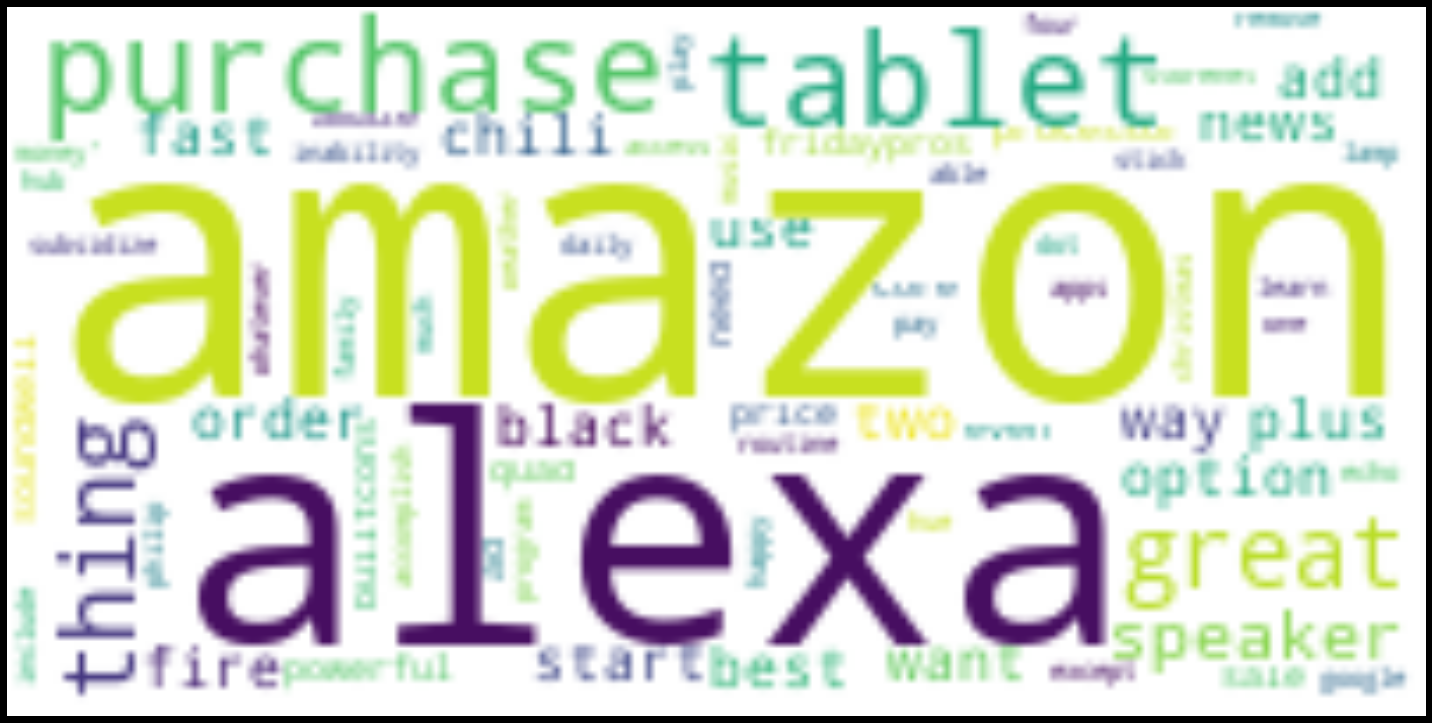

In [ ]:
from wordcloud import WordCloud, STOPWORDS
txt = data2["Processed_Review"].values
wc = WordCloud(width=200, height=100, background_color="white", stopwords=STOPWORDS).generate(str(txt))
fig = plt.figure(figsize=(20,20), facecolor='k', edgecolor='w')
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()